In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import pandas as pd
import numpy as np
from numpy import *
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

import pickle
from keras import backend as K

from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model

In [2]:
max_text_len=100
max_summary_len=15

In [3]:
post_pre = pd.read_csv ('../Dataset/Indonesian News Dataset Preprocessed 3.csv', sep=';')

In [4]:
#Add sostok and eostok at 
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

post_pre['text'] = post_pre['text'].astype(str)
post_pre['summary'] = post_pre['summary'].astype(str)

In [5]:
post_pre.head()

,text,summary
0,saurav kant an alumnus of upgrad and iiit pg p...,sostok _START_ upgrad learner switches to care...
1,kunal shah credit card bill payment platform c...,sostok _START_ delhi techie wins free food fro...
2,new zealand defeated india by wickets in the f...,sostok _START_ new zealand end rohit sharma le...
3,with aegon life iterm insurance plan customers...,sostok _START_ aegon life iterm insurance plan...
4,speaking about the sexual harassment allegatio...,sostok _START_ have known hirani for yrs what ...


In [6]:
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [7]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [8]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 57.979876941698606
Total Coverage of rare words: 1.3458992322252208


In [9]:
#prepare a tokenizer for reviews on training data
# x_tokenizer = Tokenizer() 
# x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc = len(x_tokenizer.word_index) + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 79313


In [10]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [11]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.38484557947645
Total Coverage of rare words: 3.577139684566079


In [12]:
#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc = len(y_tokenizer.word_index) + 1

print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 34420


We will now remove "Summary" i.e Y (both train and val) which has only _START_ and _END_

In [13]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [14]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [15]:
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Size of vocabulary from the w2v model = 79313
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 200)             1586260   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 lstm (LSTM)                 [(None, 100, 300),           601200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]      

In [16]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [17]:
# Define early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [18]:
# Training with a progress bar
hist = model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=25,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

# Save model, kalau mau load pake cell bawah
model.save('../Model/final_trained_model3.h5')

Epoch 1/25
690/690 [==============================] - 717s 1s/step - loss: 5.9479 - val_loss: 5.4762
Epoch 2/25
690/690 [==============================] - 717s 1s/step - loss: 5.5256 - val_loss: 5.3522
Epoch 3/25
690/690 [==============================] - 717s 1s/step - loss: 5.4179 - val_loss: 5.2732
Epoch 4/25
690/690 [==============================] - 717s 1s/step - loss: 5.3514 - val_loss: 5.2470
Epoch 5/25
690/690 [==============================] - 711s 1s/step - loss: 5.2973 - val_loss: 5.1939
Epoch 6/25
690/690 [==============================] - 710s 1s/step - loss: 5.2484 - val_loss: 5.1577
Epoch 7/25
690/690 [==============================] - 709s 1s/step - loss: 5.2010 - val_loss: 5.1144
Epoch 8/25
690/690 [==============================] - 710s 1s/step - loss: 5.1501 - val_loss: 5.0652
Epoch 9/25
690/690 [==============================] - 709s 1s/step - loss: 5.0946 - val_loss: 5.0298
Epoch 10/25
690/690 [==============================] - 710s 1s/step - loss: 5.0359 - val_lo

In [19]:
# save:
f = open('../Model/seq2seq_trained_model_history3.pckl', 'wb')
pickle.dump(hist.history, f)
f.close()

In [20]:
# retrieve:    
f = open('../Model/seq2seq_trained_model_history3.pckl', 'rb')
history = pickle.load(f)
f.close()

In [21]:
# Load saved model

checkpoint_path = "../Model/final_trained_model3.h5"

loaded_model = load_model(checkpoint_path)

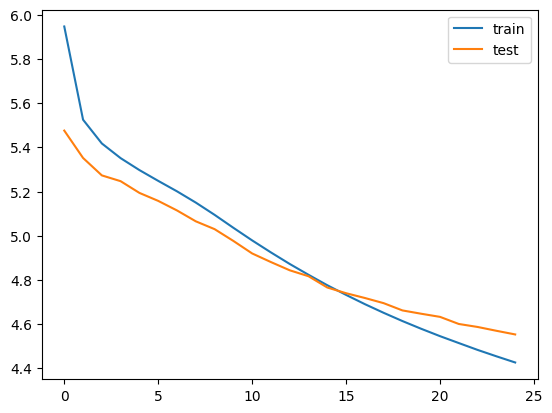

In [22]:
# Plot history
pyplot.plot(history['loss'], label='train')
pyplot.plot(history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Next, let’s build the dictionary to convert the index to word for target and source vocabulary:**

In [23]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [24]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

**We are defining a function below which is the implementation of the inference process**

In [25]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

**Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:**


In [26]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

**Run the model over the data to see the results**

In [27]:
# Input your text
input_text = ""

# Preprocess the input text
input_sequence = x_tokenizer.texts_to_sequences([input_text])
input_sequence = pad_sequences(input_sequence, maxlen=max_text_len, padding='post')

# Get the model's predicted summary
predicted_summary = decode_sequence(input_sequence)

# Print the input text and the predicted summary
print("Input Text:", input_text)
print("Predicted Summary:", predicted_summary)

1/1 [==============================] - 0s 11ms/step
Input Text: 
Predicted Summary:  start i am not to be the world cup of india end


In [28]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: the us justice department has asked the supreme court to block judge ruling that prevented president donald trump travel ban from being applied to grandparents of us citizens and refugees already being processed by resettlement agencies notably the supreme court had last month ruled that people with bona fide relationship to us person could not be barred 
Original summary: start trump admin challenges travel ban ruling in supreme court end 
1/1 [==============================] - 0s 11ms/step
Predicted summary:  start i am not to be the world cup of india end


Review: mizoram chief minister lal thanhawla has said that the congress would retain power in the state by getting full majority we are winning in at least 27 of the 40 seats thanhawla asserted the congress would get the votes of the chakmas apart from the mizos the cm said 49 voter turnout was recorded till pm in the state 
Original summary: start congress will get full majority in mizoram cm lal thanhawla end 
1/1 [====